In [10]:
import numpy as np
import keras 
from keras import layers
import tensorflow as tf

In [3]:
train_data_set = keras.preprocessing.image_dataset.image_dataset_from_directory('/content/drive/MyDrive/Hackathon/dataset/training/training',
                                                                          labels='inferred',
                                                                          label_mode='int',
                                                                          color_mode='rgb',
                                                                          batch_size=32,
                                                                          seed=1337,
                                                                          image_size=(64,64),
                                                                          validation_split=0.3,
                                                                          subset="training")

validation_data_set = keras.preprocessing.image_dataset.image_dataset_from_directory('/content/drive/MyDrive/Hackathon/dataset/training/training',
                                                                          labels='inferred',
                                                                          label_mode='int',
                                                                          color_mode='rgb',
                                                                          batch_size=32,
                                                                          seed=1337,
                                                                          image_size=(64,64),
                                                                          validation_split=0.3,
                                                                          subset="validation")

Found 5876 files belonging to 2 classes.
Using 4114 files for training.
Found 5876 files belonging to 2 classes.
Using 1762 files for validation.


In [4]:
import os

train_data_set = train_data_set.prefetch(buffer_size=32)
validation_data_set = validation_data_set.prefetch(buffer_size=32)

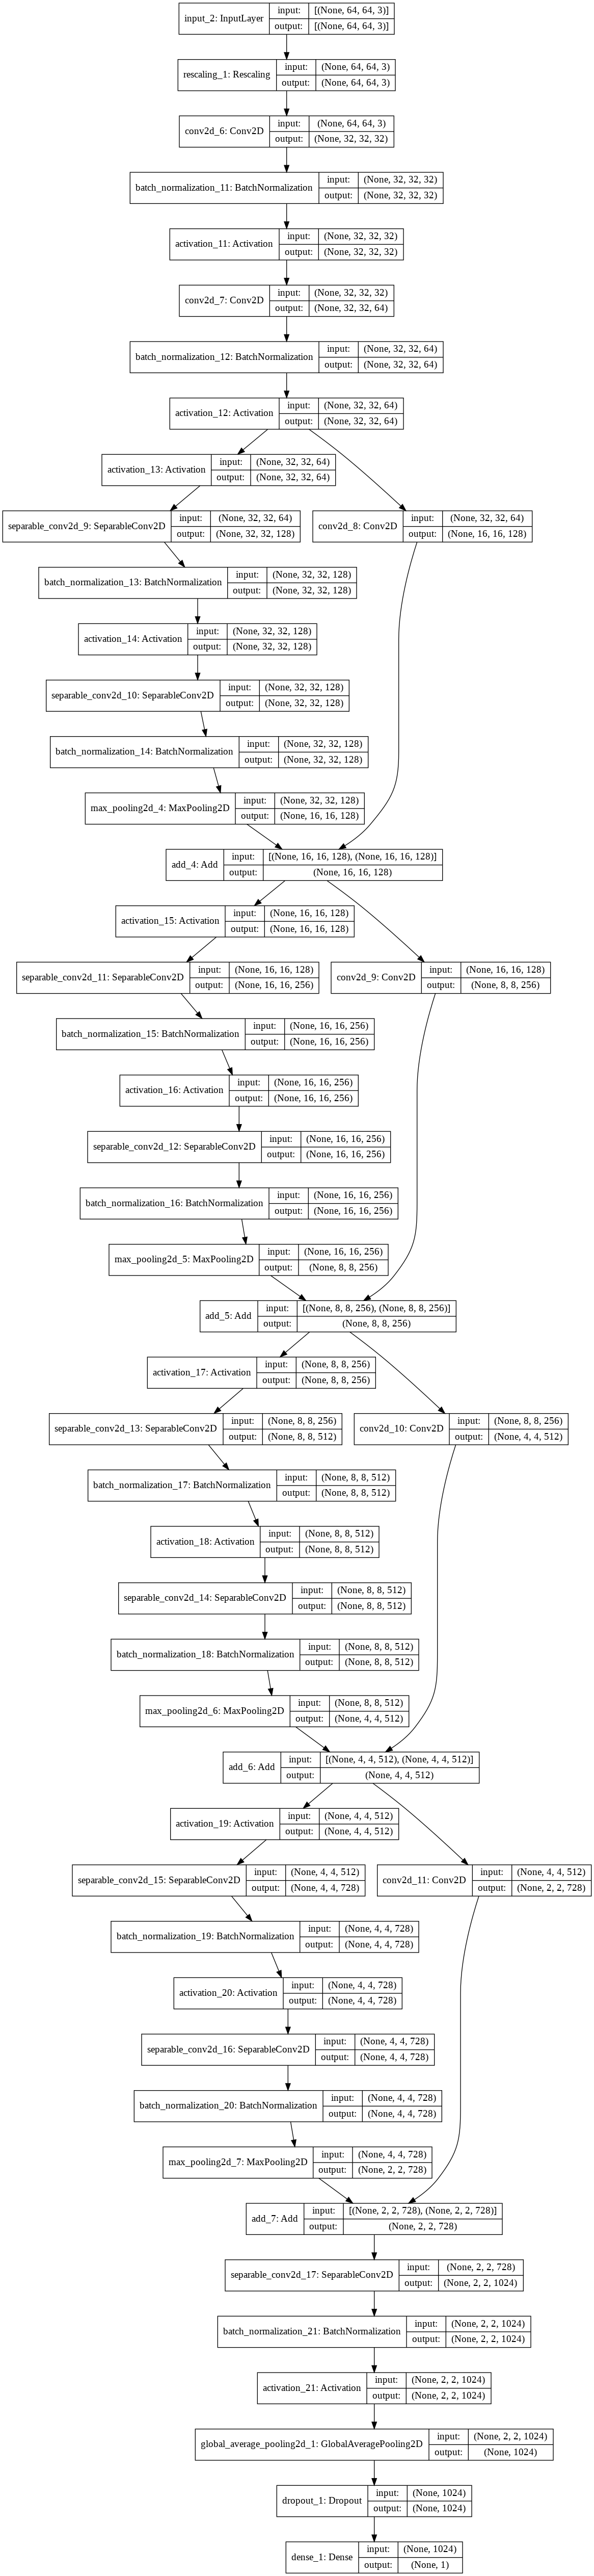

In [6]:


def make_model(input_shape):
    inputs = keras.Input(shape=input_shape)

    # Entry block
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual

    for size in [128, 256, 512, 728]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)

    activation = "sigmoid"
    units = 1
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs)


model = make_model(input_shape=(64,64) + (3,))
keras.utils.vis_utils.plot_model(model, show_shapes=True)

In [11]:
epochs = 15

callbacks = [
    keras.callbacks.ModelCheckpoint("/content/drive/MyDrive/Hackathon/models/model_save_at_{epoch}.h5"),
  ]

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy"],
  )

model.fit(
    train_data_set, epochs=epochs, callbacks=callbacks, validation_data=validation_data_set,
  )

Epoch 1/15
129/129 [==============================] - 608s 4s/step - loss: 0.3343 - accuracy: 0.8571 - val_loss: 0.5959 - val_accuracy: 0.7582


/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/15
129/129 [==============================] - 12s 87ms/step - loss: 0.1463 - accuracy: 0.9487 - val_loss: 1.1106 - val_accuracy: 0.7582
Epoch 3/15
129/129 [==============================] - 12s 90ms/step - loss: 0.0883 - accuracy: 0.9694 - val_loss: 1.4093 - val_accuracy: 0.7582
Epoch 4/15
129/129 [==============================] - 12s 93ms/step - loss: 0.0664 - accuracy: 0.9774 - val_loss: 0.5144 - val_accuracy: 0.8473
Epoch 5/15
129/129 [==============================] - 12s 94ms/step - loss: 0.0549 - accuracy: 0.9801 - val_loss: 0.1002 - val_accuracy: 0.9625
Epoch 6/15
129/129 [==============================] - 13s 96ms/step - loss: 0.0463 - accuracy: 0.9832 - val_loss: 0.1042 - val_accuracy: 0.9591
Epoch 7/15
129/129 [==============================] - 13s 98ms/step - loss: 0.0423 - accuracy: 0.9852 - val_loss: 2.5572 - val_accuracy: 0.5420
Epoch 8/15
129/129 [==============================] - 13s 97ms/step - loss: 0.0418 - accuracy: 0.9835 - val_loss: 0.0379 - val_accuracy:

In [32]:
img = keras.preprocessing.image.load_img(
    "/content/drive/MyDrive/Hackathon/dataset/test/test/68.jpg", target_size=(64,64)
  )
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)  
predictions = model.predict(img_array)
score = predictions[0]

In [33]:
score

array([0.58867335], dtype=float32)

In [55]:
from tensorflow.python.ops.gen_array_ops import expand_dims

output_predictions = dict()

for root,dirs,files in os.walk("/content/drive/MyDrive/Hackathon/dataset/test/test",topdown=True):
  for file_name in files:
    img = keras.preprocessing.image.load_img(os.path.join("/content/drive/MyDrive/Hackathon/dataset/test/test",file_name),target_size=(64,64))
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array,0)
    predictions = model.predict(img_array)
    score = 0
    if predictions[0]>0.05:
      score = 1
    output_predictions[file_name] = score


In [59]:
import json
with open("/content/drive/MyDrive/Hackathon/predictions.json","w")as f:
  json.dump(output_predictions,f)

In [57]:
output_predictions

{'1.jpg': 1,
 '10.jpg': 0,
 '11.jpg': 1,
 '12.jpg': 0,
 '13.jpg': 1,
 '14.jpg': 1,
 '15.jpg': 1,
 '16.jpg': 0,
 '17.jpg': 1,
 '18.jpg': 0,
 '19.jpg': 1,
 '2.jpg': 0,
 '20.jpg': 1,
 '21.jpg': 1,
 '22.jpg': 1,
 '23.jpg': 1,
 '24.jpg': 1,
 '25.jpg': 1,
 '26.jpg': 1,
 '27.jpg': 1,
 '28.jpg': 1,
 '29.jpg': 1,
 '3.jpg': 1,
 '30.jpg': 1,
 '31.jpg': 0,
 '32.jpg': 0,
 '33.jpg': 0,
 '34.jpg': 0,
 '35.jpg': 0,
 '36.jpg': 0,
 '37.jpg': 0,
 '38.jpg': 0,
 '39.jpg': 0,
 '4.jpg': 0,
 '40.jpg': 1,
 '41.jpg': 0,
 '42.jpg': 1,
 '43.jpg': 0,
 '44.jpg': 1,
 '45.jpg': 0,
 '46.jpg': 1,
 '47.jpg': 0,
 '48.jpg': 1,
 '49.jpg': 0,
 '5.jpg': 1,
 '50.jpg': 1,
 '51.jpg': 1,
 '52.jpg': 1,
 '53.jpg': 1,
 '54.jpg': 1,
 '55.jpg': 1,
 '56.jpg': 0,
 '57.jpg': 0,
 '58.jpg': 0,
 '59.jpg': 0,
 '6.jpg': 0,
 '60.jpg': 0,
 '61.jpg': 1,
 '62.jpg': 1,
 '63.jpg': 1,
 '64.jpg': 0,
 '65.jpg': 0,
 '66.jpg': 0,
 '67.jpg': 1,
 '68.jpg': 1,
 '69.jpg': 1,
 '7.jpg': 1,
 '70.jpg': 1,
 '71.jpg': 1,
 '72.jpg': 1,
 '73.jpg': 1,
 '74.jpg': 0,